In [1]:
import torch

In [2]:
f = open('file1.txt', 'r').read().splitlines()[1:]

In [3]:
import numpy as np
import pandas as pd
data = pd.DataFrame([(int(x1), x2, float(x3), float(x4)) for (x1,x2,x3,x4) in (x.split(', ') for x in f)])

In [4]:
from matplotlib import pyplot as plt
#data.plot.scatter(x=0, y=3, s=[.01] * len(data))

In [5]:
classes = data[1].unique()
ctoi = {c: i for i, c in enumerate(classes)}
itoc = {i: c for i, c in enumerate(classes)}
ctoi, itoc

({'other': 0,
  'sniper': 1,
  'scout': 2,
  'engineer': 3,
  'heavy': 4,
  'pyro': 5,
  'spy': 6,
  'soldier': 7},
 {0: 'other',
  1: 'sniper',
  2: 'scout',
  3: 'engineer',
  4: 'heavy',
  5: 'pyro',
  6: 'spy',
  7: 'soldier'})

In [6]:
X = torch.tensor([data[2], data[3]]).float()

#Y = torch.tensor([ctoi[c] for c in data[1]]).float()
Y = torch.nn.functional.one_hot(torch.tensor([ctoi[c] for c in data[1]]), len(classes)).float()



In [131]:
Y[1]

tensor([1., 0., 0., 0., 0., 0., 0., 0.])

In [8]:
def split_data_batches(X, Y, ratio=0.8):
    n = int(X.size(1) * ratio)
    return (X[:, :n], Y[:n, :]), (X[:, n:], Y[n:, :])

(X_train, Y_train), (X_test, Y_test) = split_data_batches(X, Y)

X_train.shape, Y_train.shape, X_test.shape, Y_test.shape

(torch.Size([2, 1337384]),
 torch.Size([1337384, 8]),
 torch.Size([2, 334346]),
 torch.Size([334346, 8]))

In [255]:
block_size = 66 * 5
batch_size = 32

# grab random blocks of data from the training set
def get_time_series_batches(data, labels, batch_size, window_size):
    num_samples = data.size(1)
    num_windows = num_samples - window_size + 1
    batch_indices = torch.randint(0, num_windows, (batch_size,))
    xs = []
    ys = []
    for idx in batch_indices:
        x = data[:, idx:idx+window_size].T
        y = labels[idx:idx+window_size, :]

        xs.append(x)
        ys.append(y)
        

    return torch.stack(xs), torch.stack(ys)


In [341]:
class Net(torch.nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        #self.fc2 = torch.nn.LSTM(block_size * 2, 50, 2, batch_first=True, bidirectional=True)
        # expects B x C x T
        self.fc1 = torch.nn.Conv1d(2, 20, 2)
        # input, hidden, layers
        self.fc2 = torch.nn.LSTM(329, 50, 2, batch_first=True, bidirectional=True)
        self.fc3 = torch.nn.Linear(100, Y.shape[1])
        #self.last = torch.nn.Softmax()

    def forward(self, x):
        x = x.view(-1, 2, block_size)
        #x = x.reshape(-1, block_size * 2)
        x = self.fc1(x)
        # x = torch.squeeze(x, dim=1)
        x = torch.relu(x)
        x,_ = self.fc2(x)
        x = torch.relu(x)
        x = self.fc3(x)
        #x = self.last(x)
        return x
    
net = Net()
loss = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(net.parameters(), lr=0.0001)

In [339]:
losses = []
validation_losses = []

In [342]:
optimizer.lr = 0.001
for epoch in range(1000):
    optimizer.zero_grad()
    X_batch, Y_batch = get_time_series_batches(X_train, Y_train, batch_size, block_size)
    Y_pred = net(X_batch)
    Y_batch = Y_batch[:, 0, :]
    #print(Y_batch.shape, Y_pred.shape)
    
    l = loss(Y_pred, Y_batch.long())
    l.backward()
    optimizer.step()
    losses.append(l.item())
    if epoch % 100 == 0:
        print(f'Epoch {epoch}: {l.item()}')

    with torch.no_grad():
        X_batch, Y_batch = get_time_series_batches(X_test, Y_test, batch_size, block_size)
        Y_pred = net(X_batch)
        Y_batch = Y_batch[:, 0, :]
        l = loss(Y_pred, Y_batch.long())
        validation_losses.append(l.item())

Epoch 0: 2.9748425483703613
Epoch 100: 2.345395565032959
Epoch 200: 1.3516733646392822
Epoch 300: 0.8310291171073914
Epoch 400: 0.5629404187202454
Epoch 500: 0.4444054663181305
Epoch 600: 0.39668765664100647
Epoch 700: 0.3804859519004822
Epoch 800: 0.3485305607318878
Epoch 900: 0.326789915561676


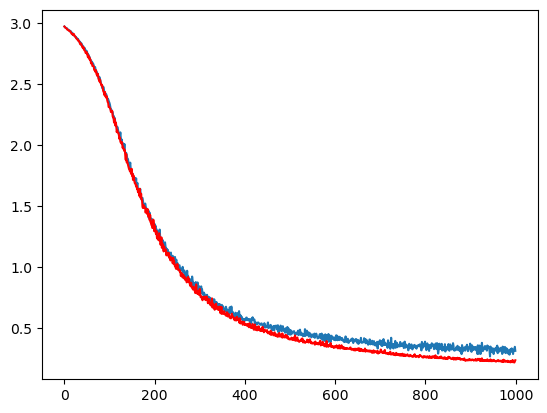

In [343]:
plt.plot(torch.tensor(losses).view(-1,1).mean(dim=(1)), label='loss')
plt.plot(torch.tensor(validation_losses).view(-1,1).mean(dim=(1)), label='vloss', color='red')

In [344]:
#print(net(validation_x[1:2, :, :]), validation_y[1:2, 0, :])
print(net(validation_x[1:2, :, :]))
print(validation_y[1:2, 0, :])

tensor([[[ 2.7477,  2.7865,  2.5556,  2.7425,  3.0261,  2.8458,  3.5156,
           2.7173],
         [ 2.7902,  1.4283,  1.9645,  1.0542,  1.4085,  1.4144,  2.2952,
           1.6842],
         [ 0.3199, -1.6968, -0.8137, -2.2574, -1.8903, -1.8328, -1.0343,
          -1.1742],
         [-1.1227, -2.7836, -2.1747, -3.3217, -3.0883, -2.8250, -2.0896,
          -2.3296],
         [-1.8200, -3.1838, -2.7163, -3.6368, -3.4810, -3.2250, -2.4768,
          -2.8203],
         [-1.9634, -3.2863, -2.7631, -3.6993, -3.6085, -3.2637, -2.5207,
          -2.8866],
         [-2.1115, -3.4652, -2.8825, -3.8067, -3.7851, -3.3691, -2.6434,
          -3.0421],
         [-2.3113, -3.5464, -3.0424, -3.8861, -3.9238, -3.4314, -2.7672,
          -3.2404],
         [-2.3341, -3.5474, -3.0613, -3.8874, -3.9222, -3.4417, -2.7757,
          -3.2541],
         [-2.3265, -3.5434, -3.0564, -3.8876, -3.9239, -3.4384, -2.7712,
          -3.2511],
         [-2.3532, -3.5239, -3.0791, -3.8769, -3.9103, -3.4385, -2.771

performance history
####

3 linear layers: loss: jittery around 1.1. valdiation loss: jittery around 0.6. single shot failed
1 linear, 1 lstm, 1 linear: loss around 1.3 validation loss: jittery around 0.7, single shot works
1 conv1d, 1lstm, 1 linear: loss around 0.6, validation loss: around 0.6, single shot
1 conv2d (flattened), 1lstm, 1linear, 1softmax: loss around 1.8, validation loss 1.3. 50% training success

In [345]:
# validation_set percent right prediction

with torch.no_grad():
    n_samples = 1000
    validation_x, validation_y = get_time_series_batches(X_train, Y_train, n_samples, block_size)
    print(validation_x.shape, validation_y.shape)
    Y_pred = net(validation_x)
    corect = 0
    for sample in range(n_samples):
        if validation_y[sample, 0, :].argmax(dim=0) == Y_pred[sample].argmax(dim=0)[0]:
            corect += 1
        #Y_true = torch.argmax(validation_y[:, :, :], dim=2)
        #print(Y_true)
    print(corect / n_samples)

torch.Size([100000, 330, 2]) torch.Size([100000, 330, 8])


RuntimeError: Boolean value of Tensor with more than one value is ambiguous

In [274]:
argmaxes = set()
for x in Y_train:
    argmaxes.add(x.argmax().item())
print(argmaxes)

{0, 1, 2, 3, 4, 5, 6, 7}
